# ANALIZA PODATKOV
Na tem mestu bomo naredili analizo podatkov, ki so zbrani v csv datotekah v mapi podatki. Analizirali bomo po treh dejavnikih:
* analiza najstarejših prebivalcev po državah in povprečni življenjski dobi po državah
*
*


Naložimo pandas in omejimo velikot tabel na največ 15 vrstic.

In [54]:
import pandas as pd
pd.set_option("display.max_rows", 15)
%matplotlib inline


Shranimo vse csv datoteke.

In [55]:
najstarejsi_prebivalci = pd.read_csv("podatki/najstarejsi_prebivalci_po_drzavah.csv", index_col="Država")
pricakovana_zivljenjska_doba = pd.read_csv("podatki/pricakovana_zivljenjska_doba_po_drzavah.csv", index_col="Država")
GDP_po_drzavah = pd.read_csv("podatki/GDP_po_drzavah.csv", index_col="Država")
podhranjenost_po_drzavah = pd.read_csv("podatki/podhranjenost_po_drzavah.csv", index_col="Država")
poraba_energije_po_drzavah = pd.read_csv("podatki/poraba_energije_po_drzavah.csv", index_col="Država")
obnovljiva_energija_po_drzavah = pd.read_csv("podatki/obnovljiva_energija_po_drzavah.csv", index_col="Država")
CO2_emisije_po_drzavah = pd.read_csv("podatki/CO2_emisije_po_drzavah.csv", index_col="Država")
kolicina_vode_po_drzavah = pd.read_csv("podatki/kolicina_vode_po_drzavah.csv", index_col="Država")


## Analiza po najstarejših prebivalcih in pričakovani življenjski dobi
V tem sklopu ananlize podatkov bomo primerjali starost najstarejših oseb po državah in pričakovani življenjski dobi po državah. Sprva bomo uredili tabelo najstarejših prebivalcev, nato ju bomo združili. Vsaka država bo imela moškega in žensko predstavnico, ki bosta izbrana na podlagi najdaljšega življenja (saj imajo nekatere države več kot dva predstavnika). Če država nima enaga od predstavnikov, ga bomo izpustili. Hkrati se tudi lahko zgodi, da nekaterih držav ni navedenih v obeh tabelah podatkov. Te države prav tako izpustimo.  

In [75]:
# Najprej dodamo še en stolpec, predstavlja starost v decimalnem zapisu
najstarejsi_prebivalci['starost (skupna)'] = najstarejsi_prebivalci['Starost (leta)'] + najstarejsi_prebivalci['Starost (dnevi)']/365
najstarejsi_prebivalci['starost (skupna)'] = najstarejsi_prebivalci['starost (skupna)'].round(2)
# Razvrstimo po starosti (najprej leta padajoče, nato dnevi padajoče) znotraj države in spola
najstarejsi_prebivalci_vrstni_red = najstarejsi_prebivalci.sort_values(by=['Država', 'Spol', 'Starost (leta)', 'Starost (dnevi)'], ascending=[True, True, False, False])

# Za vsako kombinacijo države in spola vzamemo prvo vrstico (najstarejšo)
najstarejsi_prebivalci_urejena = najstarejsi_prebivalci_vrstni_red.groupby(['Država', 'Spol']).first().reset_index()

# Zdaj imamo za vsako državo in spol eno vrstico
# Za vsako državo vzamemo največ dve vrstici (eno za vsak spol)
# Najprej dodamo pomocni stolpec za razvrstitev znotraj države (po spolu, npr. F prvi, M drugi)
najstarejsi_prebivalci_urejena['Spol_razvrstitev'] = najstarejsi_prebivalci_urejena['Spol'].apply(lambda x: 0 if x == 'F' else 1)
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_urejena.sort_values(by=['Država', 'Spol_razvrstitev'])

# Zdaj za vsako državo vzamemo največ dve vrstici
najstarejsi_prebivalci_sortirana.groupby('Država').head(2).reset_index(drop=True)

# Odstranimo pomocni stolpec
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_sortirana.drop(columns=['Spol_razvrstitev'])
najstarejsi_prebivalci_sortirana

,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),starost (skupna)
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46
2,Algeria,F,5 October 1890,26 March 2005,114,172,114.47
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18
...,...,...,...,...,...,...,...
164,United States,M,16 August 1882,25 April 1998,115,252,115.69
165,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21
166,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32
167,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34


Sedaj združimo to tabelo s tabelo o pričakovani življenjski dobi. Združili jih bomo tako, da v nov stolpec dodamo indeks pričakovane življenjske dobe, ki je odvisen od države in spola osebe.

In [76]:
# Združimo tabeli po državi
zdruzena_tabela = pd.merge(najstarejsi_prebivalci_sortirana, pricakovana_zivljenjska_doba, on='Država', how='left')

# Dodamo nov stolpec z indeksom pričakovane življenjske dobe
zdruzena_tabela['Pričakovana življenjska doba po spolu'] = zdruzena_tabela.apply(
    lambda row: row['Pričakovana življenjska doba (ženske)'] if row['Spol'] == 'F' 
    else row['Pričakovana življenjska doba (moški)'] if row['Spol'] == 'M' 
    else None, 
    axis=1
)

# Razvrstimo po državah in spolu
zdruzena_tabela = zdruzena_tabela.sort_values(by=['Država', 'Spol'])
zdruzena_tabela = zdruzena_tabela.drop(columns=['Pričakovana življenjska doba', 'Pričakovana življenjska doba (ženske)', 'Pričakovana življenjska doba (moški)'])
zdruzena_tabela



,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),starost (skupna),Pričakovana življenjska doba po spolu
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15,81.74
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46,78.12
2,Algeria,F,5 October 1890,26 March 2005,114,172,114.47,78.13
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42,75.30
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18,67.54
...,...,...,...,...,...,...,...,...
164,United States,M,16 August 1882,25 April 1998,115,252,115.69,77.22
165,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21,82.17
166,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32,74.59
167,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34,76.82


Z grafom predstavimo podatke spodnje tabele - starost s pričakovano življenjsko dobo po spolu.

In [ ]:
graf1_tabela = zdruzena_tabela[['starost (skupna)', 'Pričakovana življenjska doba po spolu']]
graf1_tabela 

,starost (skupna),Pričakovana življenjska doba po spolu
0,111.15,81.74
1,109.46,78.12
2,114.47,78.13
3,111.42,75.30
4,112.18,67.54
...,...,...
164,115.69,77.22
165,112.21,82.17
166,110.32,74.59
167,112.34,76.82


<Axes: title={'center': 'Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo'}, xlabel='Pričakovana življenjska doba', ylabel='Starost'>

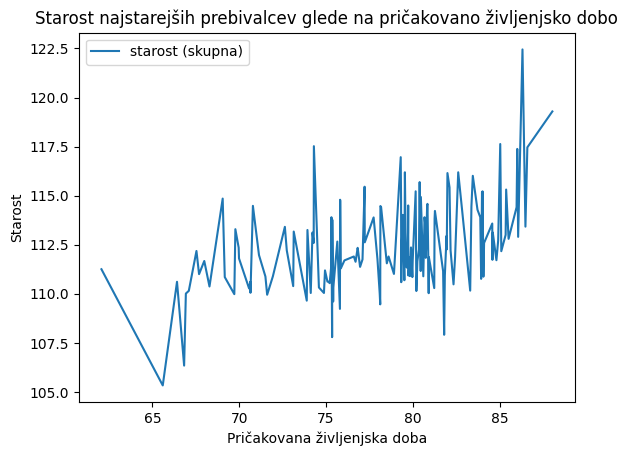

In [97]:
graf1_tabela.groupby("Pričakovana življenjska doba po spolu").mean().plot(ylabel = "Starost", xlabel = "Pričakovana življenjska doba", title = "Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo")

Opaženo je tako, da je korelacija med starostjo in pričakovano življenjsko dobo, saj graf narašča.